In [50]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from scipy.signal import hilbert, butter, lfilter, freqz
from samplerate import resample
from librosa import stft, istft
import sys
import IPython.display as ipd
from numpy import hanning
import mir_eval
from SpikeSep import triggers, multi_stft, remove_trigger, estimate_fw_mapping, step_bf, break_small

In [74]:
# low pass 
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
def remove_trigger(signal):
    trigger_index = np.where(signal > 20000)[0][-1]
    signal_trigger_removed = signal[trigger_index + 1:]
    return signal_trigger_removed

def multi_stft(x, frame_len, frame_step, window=np.hanning):
    s = np.array([stft(xx, frame_len, frame_step, window=window) for xx in x])
    return s

def m_nica(y, x, max_iter=100, n=2, th=0.95, verbose=False, patience=10):
    zm_x = x - np.mean(x, axis=1, keepdims=True)
    t = y.shape[-1]
    S_init = np.abs(y[:n, :])
    _, _, V = np.linalg.svd(y, full_matrices=True)
    V = V.T
    V_not = V[:,:n]
    oneM = np.ones((t,1))
    S_prev = S_init
    iteration = 1
    ex = 0
    pat_count = 0
    last_best = 0
    for i in range(max_iter):

        S_not = 1.0 / t * (S_prev).dot(oneM.dot(oneM.T)) 

        C_s = (S_prev - S_not).dot((S_prev - S_not).T)

        D1_i = np.linalg.inv(np.diag(np.diag(C_s)))

        D2 = np.diag(np.diag((D1_i.dot(C_s)) ** 2))

        S_temp = S_prev * \
        (S_not.dot(S_prev.T).dot(D1_i).dot(S_prev) + S_prev.dot(S_prev.T).dot(D1_i).dot(S_not) + D2.dot(S_prev))/\
         (S_not.dot(S_prev.T).dot( D1_i).dot(S_not) + S_prev.dot(S_prev.T).dot(D1_i).dot(S_prev) + D2.dot(S_not))

        S_prev = np.clip(S_temp.dot(V_not).dot(V_not.T), 0, np.Inf)
        norm_S_prev = S_prev / np.max(S_prev, axis=1, keepdims=True)
        zm_S_prev = norm_S_prev - np.mean(norm_S_prev, axis=1, keepdims=True)
        
        corrs = []
        corrs.append([np.corrcoef(zm_S_prev[0,:],zm_x[0,:])[0,1], np.corrcoef(zm_S_prev[1,:],zm_x[1,:])[0,1]])
        corrs.append([np.corrcoef(zm_S_prev[1,:],zm_x[0,:])[0,1], np.corrcoef(zm_S_prev[0,:],zm_x[1,:])[0,1]])
        
        arg = np.argmax([np.sum(corrs[0]), np.sum(corrs[1])])
        if np.sum(corrs[arg]) - 0.01 < last_best:
            pat_count += 1
            if pat_count == patience:
                break
        else:
            last_best = np.sum(corrs[arg])

        iteration +=  1
        if verbose:
            sys.stdout.write("\rIteration %d: %.4f || %.4f " % (iteration, corrs[arg][0], corrs[arg][1]))
        if corrs[0][0] > th and corrs[0][1] > th :
            ex = 2
            break
        if corrs[1][0] > th and corrs[1][1] > th :
            ex = 1
            break

    est1 = norm_S_prev[0,:]
    est2 = norm_S_prev[1,:]
    
    if ex == 1:
        ori1 = x[0,:]
        ori2 = x[1,:]
    else:
        ori1 = x[1,:]
        ori2 = x[0,:]
    
    return np.array([est1, est2]), np.array([ori1, ori2])


(2, 10820)
(8, 10820)
Iteration 28: 0.9753 || 0.8541 

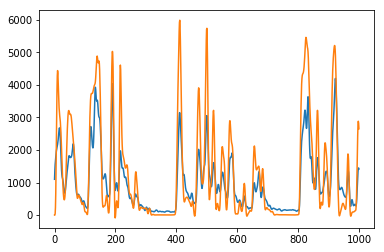

In [81]:
pos = [1,8]
sample = 'C'
base_dir = '/Data/Dropbox/Shared ISCAS2017Submissions/RecordingsDungeon/'
prefix_filenames = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/dungeon_concurrent_'

filename_id = '%d_%d_%s' %(pos[0], pos[1], sample)
filename_whisper1 = prefix_filenames + filename_id + '_1.wav'
filename_whisper3 = prefix_filenames + filename_id + '_3.wav'
filename_groundtruth1 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s1_T.wav' %sample
filename_groundtruth8 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s8_T.wav' %sample
fs, whisper1 = wavfile.read(filename_whisper1)
fs, whisper3 = wavfile.read(filename_whisper3)
# plt.plot(whisper1[:115000, 0])
# ipd.display(ipd.Audio(whisper1[:200000, 0], rate=fs))
TR = 10000 if sample in ['A', 'C'] and pos == [9, 7] else 18000
trigger_index = np.where(whisper1>TR)[0][0]
# print trigger_index
# trigger_index = 115000
whisper1 = whisper1[trigger_index + int(fs / 32):]
whisper3 = whisper3[trigger_index + int(fs / 32):]

# make the same length
shortest_size = np.amin((whisper1.shape[0], whisper3.shape[0]))
whisper1_shortened = whisper1[:shortest_size,:]
whisper3_shortened = whisper3[:shortest_size,:]
whisper = np.concatenate((whisper1_shortened,whisper3_shortened),1)

# gt
_, groundtruth1 = wavfile.read(filename_groundtruth1)
groundtruth1 = remove_trigger(groundtruth1)
_, groundtruth8 = wavfile.read(filename_groundtruth8)
groundtruth8 = remove_trigger(groundtruth8)

# stfts & VADs
res_f = 200
# m1_sum = resample(groundtruth1, res_f / fs)
# m2_sum = resample(groundtruth8, res_f / fs)

windowSize = 2048
fftSize = windowSize
hopSize = 120
windowFunction = hanning

m2 = stft(groundtruth8, windowSize, hopSize, window=np.hanning).T
m1 = stft(groundtruth1, windowSize, hopSize, window=np.hanning).T

Wn = 20
env1 = butter_lowpass_filter(np.abs(hilbert(groundtruth1, N=int(2 ** np.ceil(np.log2(len(groundtruth1)))))), Wn, fs)
env2 = butter_lowpass_filter(np.abs(hilbert(groundtruth8, N=int(2 ** np.ceil(np.log2(len(groundtruth8)))))), Wn, fs)

env1 = env1[:len(groundtruth1)]
env2 = env2[:len(groundtruth8)]

env1 = resample(env1, res_f / fs)
env2 = resample(env2, res_f / fs)


# stfts & VADs
VAD1 = np.array(0.8 * env1 > env2)
VAD2 = np.array(0.8 * env2 > env1)

x_spec = np.transpose(multi_stft(whisper.T, windowSize, hopSize), (0, 2, 1))


Y = np.array([resample(butter_lowpass_filter(np.abs(hilbert(x, N=int(2 ** np.ceil(np.log2(len(x)))))), Wn, fs), res_f / fs) for x in whisper.T])

ori = np.array([env1, env2])
print ori.shape
Y = Y[:, :ori.shape[1]]
print Y.shape



pp = np.correlate(Y[0][:1000], ori[0][:1000], 'full')
j0 = np.argmax(pp) - 1000

if j0 > 0:
    Y = Y[:, j0:]
    ori = ori[:, :-j0]
else:
    ori = ori[abs(j0):]
    Y = Y[:, :-abs(j0)]

plt.plot(Y[0][:1000])
plt.plot(ori[0][:1000])

# m-nica and vad
est, o = m_nica(Y, ori, verbose=True, max_iter=500, th=0.9, patience=10)
th = 0.9
vad1 = np.float32(est[0] * th > est[1])
vad2 = np.float32(est[1] * th > est[0])

VAD1 = VAD1[:len(vad1)]
VAD2 = VAD2[:len(vad2)]


CORR: -0.6956 || -0.6927
Estimated JIT -2.5 || Theoretical JIT = 2
AFTER: -0.678 || -0.667


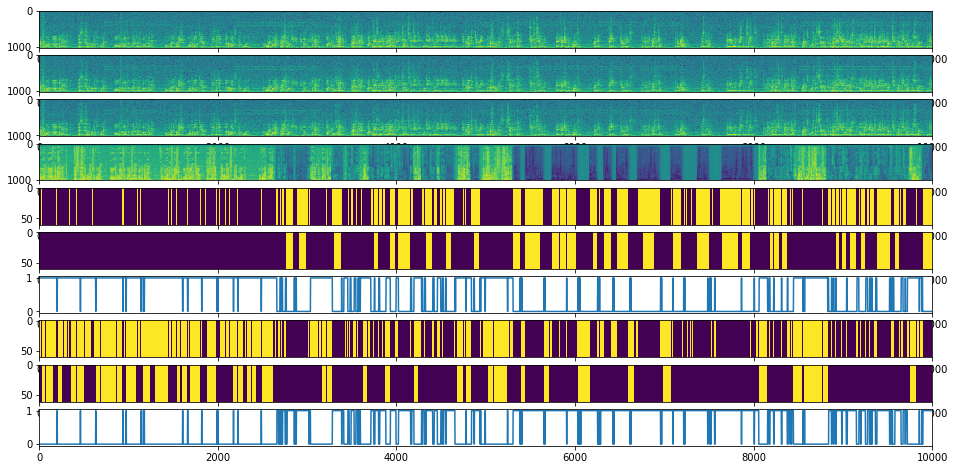

In [78]:
JIT = 2
LP = 5
sampleRate = fs
BW_ms = 200
BW = int(np.ceil(BW_ms / 1000.0 * fs / hopSize))
# solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(frame_len / 2 + 1)))
# solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(frame_len / 2 + 1)))
solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(hopSize/ 2 + 1)))
solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(hopSize / 2 + 1)))

solid_vad11 = np.tile(np.expand_dims(break_small(vad1, BW), -1), (1, int(hopSize / 2 + 1)))
solid_vad22 = np.tile(np.expand_dims(break_small(vad2, BW), -1), (1, int(hopSize / 2 + 1)))

print("CORR: {:.4} || {:.4}".format(np.corrcoef(vad1, VAD1)[0,1], np.corrcoef(vad2, VAD2)[0,1]))
mc1 = np.argmax(np.correlate(vad1, VAD1, "full")) - len(VAD1)
mc2 = np.argmax(np.correlate(vad2, VAD2, "full")) - len(VAD2)
print("Estimated JIT {} || Theoretical JIT = {}".format(np.mean([mc1, mc2]), JIT))
# JIT = int(np.mean([mc1, mc2])
print("AFTER: {:.4} || {:.4}".format(np.corrcoef(vad1[JIT:], VAD1[:-JIT])[0,1], np.corrcoef(vad2[JIT:], VAD2[:-JIT])[0,1]))
# JIT = 140
# print solid_vad1.shape
lim0 = int(sampleRate * 0 / hopSize)
lim1 = int(sampleRate * 50 / hopSize)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(10,1,1)
ax.imshow(np.log(np.abs(x_spec[0][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,2)
ax.imshow(np.log(np.abs(x_spec[1][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,3)
ax.imshow(np.log(np.abs(x_spec[2][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,4)
pos1 = np.abs(m1[lim0:lim1, ::-1]) 
neg1 = np.abs(m2[lim0:lim1, ::-1]) 
ax.imshow((np.log(pos1 + 1) - np.log(neg1 + 1)).T , aspect="auto")
ax = fig.add_subplot(10,1,5)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad1[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,6)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad11[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,7)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD1[lim0:lim1].T)
ax = fig.add_subplot(10,1,8)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad2[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,9)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad22[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,10)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD2[lim0:lim1].T)

In [79]:
ch0 = np.array([0,1,2,5,6,3])
ch1 = np.array([0,1,2,5,6,3])

_, _, vad_slice = triggers(sample, sampleRate, hopSize, JIT)
_, _, spec_slice = triggers(sample, sampleRate, hopSize)
x_spec = x_spec[:, :len(vad1), :]

recons = []
for vad, ch in zip([vad1, vad2], [ch0, ch1]):
    # vad = vad[vad_slice]
    vad = np.expand_dims(np.expand_dims(break_small(vad, BW), 0), -1)
    # vad = np.concatenate([vad[:, vad_slice[0]], vad[:, vad_slice[1]]], axis=1)
    xx = []
    for v_sl, x_sl in zip(vad_slice, spec_slice):
        xx += [x_spec[ch, x_sl] * vad[:, v_sl]]
    # x_spec_a = x_spec[:, spec_slice]
    # x_spec_a = x_spec_a[:, :vad.shape[1]]
    ll1 = estimate_fw_mapping(np.concatenate(xx, axis=1))
    x_spec_b = x_spec[ch].T
    w = step_bf(x_spec_b, ll1)
    recons.append(np.einsum('ab,acb->ca', np.conj(w), x_spec_b))

recons[0] = istft(recons[0].T, hopSize, window=np.hanning)
recons[1] = istft(recons[1].T, hopSize, window=np.hanning)

In [80]:
# correct for filter length
init1 = 0
init0 = int(26 * sampleRate) if sample == 'A' else int(13 * sampleRate)
init2 = int(40 * sampleRate) if sample == 'A' else int(26 * sampleRate)
recons0 = recons[0][init0:init2]
recons1 = recons[1][init0:init2]
groundtruth11 = groundtruth1[init0:]
groundtruth88 = groundtruth8[init0:]

end = 100000

pp = np.correlate(recons1[init1:init1 + end], groundtruth88[init1:init1 + end], 'full')
j1 = np.argmax(pp) - end

pp = np.correlate(recons0[init1:init1 + end], groundtruth11[init1:init1 + end], 'full')
j0 = np.argmax(pp) - end

print("{} || {}".format(j0, j1))

if j0 > 0:
    recons0 = recons0[j0:]
else:
    groundtruth11 = groundtruth11[abs(j0):]
        
if j1 > 0:
    recons1 = recons1[j1:]
else:
    groundtruth88 = groundtruth88[abs(j1):]
min_len = np.min([len(recons0), len(recons1), len(groundtruth11), len(groundtruth88)])
recons0 = recons0[:min_len]
recons1 = recons1[:min_len]
groundtruth11 = groundtruth11[:min_len]
groundtruth88 = groundtruth88[:min_len]

# fig = plt.figure(figsize=(16,2))
# ax = fig.add_subplot(1,2,1)
# ax.plot(recons0 / np.max(abs(recons0)))
# ax.plot(groundtruth11 / np.max(np.abs(groundtruth11)))
# # ax.plot(whisper[:, 0] / np.max(np.abs(whisper[:, 0])))
# ax = fig.add_subplot(1,2,2)
# ax.plot(recons1 / np.max(abs(recons1)))
# ax.plot(groundtruth88 / np.max(np.abs(groundtruth88)))

ipd.display(ipd.Audio(recons0[:200000], rate=sampleRate))
ipd.display(ipd.Audio(recons1[:200000], rate=sampleRate))
ipd.display(ipd.Audio(groundtruth11[:200000], rate=sampleRate))
ipd.display(ipd.Audio(groundtruth88[:200000], rate=sampleRate))
sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(np.array([groundtruth11, groundtruth88]), np.array([recons0, recons1]))
print("SIR {}".format(sir))
print(sdr)

5466 || -2025


SIR [20.77666797  4.37245235]
[ -5.97044356 -25.38028946]
